# Introduction

Currently, one of the most common (and accurate) methods for conducting a Blood
Smear is manually. The goal of this project is to develop a neural network that can classify WBCs from images as part of an eventual effort to automate the procedure without a significant loss in accuracy. By automating this process, we can not only speed it up, but we also reduce the amount of human labor required to conduct a test, thus lowering the overall cost.

The dataset for this project is a collection of ~12,500 images that are 240 x 320. The images contain several RBCs and a single, highlighted WBC. Each WBC falls into one of four categories: Eosinophil, Lymphocyte, Monocyte, or Neutrophil. The dataset can be found on Kaggle [here](https://www.kaggle.com/paultimothymooney/blood-cells). Through accurate classification, accurate proportions of each WBC type could be calculated and checked for normalcy. Additionally, cell images could be further inspected for abnormalities.

# Module Imports

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from PIL import Image
from tqdm import tqdm
import os
import matplotlib.pyplot as plt
%matplotlib inline


import warnings  
with warnings.catch_warnings():  
    warnings.filterwarnings("ignore",category=FutureWarning)
    import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adadelta

# Data Exploration

Let's begin by taking a look at an example of each of the four types of WBC we'll be attempting to classify.

In [2]:
wbc_types = ['EOSINOPHIL', 'NEUTROPHIL', 'LYMPHOCYTE', 'MONOCYTE']
wbc_df = pd.DataFrame(columns=['file_name', 'type', 'group'])
X_train = []
X_test = []
y_train = []
y_test = []

plt.figure(figsize=(10,8))

for i, wbc_type in enumerate(wbc_types):
    path = 'dataset2-master/images/TRAIN/' + wbc_type + '/'
    files = os.listdir(path)
    print("Loading {} Training Image Files".format(wbc_type))
    for file in tqdm(files):
        image = load_img(path + file)
        image = image.resize((150,150))
        new_row = {'file_name': file,
                   'type': wbc_type, 
                   'group': 'train'}
        wbc_df = wbc_df.append(new_row, ignore_index=True)
        X_train.append(np.asarray(image))
        y_train.append(i)
    path2 = 'dataset2-master/images/TEST/' + wbc_type + '/'
    files2 = os.listdir(path2)
    print("Loading {} Testing Image Files".format(wbc_type))
    for file2 in tqdm(files2):
        image = load_img(path2 + file2)
        image = image.resize((150,150))
        new_row = {'file_name': file2,
                   'type': wbc_type,
                   'group': 'test'}
        wbc_df = wbc_df.append(new_row, ignore_index=True)
        X_test.append(np.asarray(image))
        y_test.append(i)
    
#     df = pd.DataFrame(columns=['file_name', 'type'])
#     df['file_name'] = files
#     df.fillna(value=wbc_type, inplace=True)
#     wbc_df = wbc_df.append(df)
    
#     image = load_img(path + files[0])
#     plt.subplot(2,2,i+1)
#     plt.title(wbc_type)
#     plt.axis('off')
#     plt.imshow(image)
    
# plt.tight_layout()
# plt.show()

  0%|                                                 | 0/2497 [00:00<?, ?it/s]

Loading EOSINOPHIL Training Image Files


  1%|▎                                         | 5/623 [00:00<00:13, 46.45it/s]

Loading EOSINOPHIL Testing Image Files


  0%|                                         | 6/2499 [00:00<00:43, 56.87it/s]

Loading NEUTROPHIL Training Image Files


  1%|▍                                         | 7/624 [00:00<00:09, 63.02it/s]

Loading NEUTROPHIL Testing Image Files


  0%|                                         | 6/2483 [00:00<00:49, 49.68it/s]

Loading LYMPHOCYTE Training Image Files


  1%|▍                                         | 7/620 [00:00<00:10, 60.67it/s]

Loading LYMPHOCYTE Testing Image Files


  0%|                                         | 7/2478 [00:00<00:35, 69.73it/s]

Loading MONOCYTE Training Image Files


  1%|▎                                         | 4/620 [00:00<00:20, 29.83it/s]

Loading MONOCYTE Testing Image Files


100%|████████████████████████████████████████| 620/620 [00:14<00:00, 42.44it/s]


<Figure size 720x576 with 0 Axes>

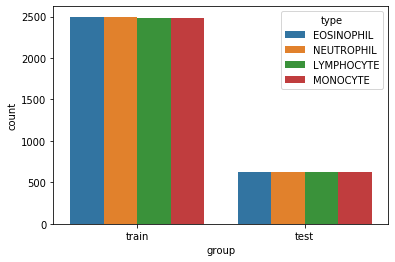

In [3]:
sns.countplot(x='group', hue='type', data=wbc_df)
plt.show()

In [4]:
X_train = np.asarray(X_train)
X_train = X_train/255.0

y_train = np.asarray(y_train)
y_train = to_categorical(y_train, num_classes=4)

X_test = np.asarray(X_test)
X_test = X_test/255.0

y_test = np.asarray(y_test)
y_test = to_categorical(y_test, num_classes=4)

In [ ]:
y_train.shape

The images show that each of the four cell types are quite easily visually differentiable. Additionally, we can see from the countplot that our training data is very well balanced with ~2,500 images of each WBC cell type.

# Model Construction

Since the input to be classified are image files, we will be using a Convolutional Neural Network for these purposes. 

In [5]:
batch_size = 128
image_height = 150
image_width = 150

# model accuracy reached 0.3155 after 1.5 hours and 30 epochs
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(image_height,image_width,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dense(64))
model.add(Activation('relu'))
#model.add(Dropout(0.5))
model.add(Dense(4))
model.add(Activation('softmax'))

optimizer = Adadelta()

model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [6]:
# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images

In [7]:
model.fit(train_datagen.flow(X_train, y_train, batch_size=32),
          steps_per_epoch=len(X_train) // 32,
          epochs=30,
          validation_data=(X_test, y_test),
          validation_steps=2487 // 32)
#model.save_weights('first_try.h5')  # always save your weights after training or during training

Epoch 1/30
311/311 [==============================] - 180s 580ms/step - loss: 1.3885 - acc: 0.2489 - val_loss: 1.3880 - val_acc: 0.2477
Epoch 2/30
311/311 [==============================] - 174s 559ms/step - loss: 1.3875 - acc: 0.2507 - val_loss: 1.3877 - val_acc: 0.2465
Epoch 3/30
311/311 [==============================] - 174s 559ms/step - loss: 1.3870 - acc: 0.2546 - val_loss: 1.3852 - val_acc: 0.2694
Epoch 4/30
311/311 [==============================] - 184s 590ms/step - loss: 1.3856 - acc: 0.2628 - val_loss: 1.3861 - val_acc: 0.2682
Epoch 5/30
311/311 [==============================] - 182s 585ms/step - loss: 1.3854 - acc: 0.2634 - val_loss: 1.3834 - val_acc: 0.2778
Epoch 6/30
311/311 [==============================] - 184s 593ms/step - loss: 1.3846 - acc: 0.2672 - val_loss: 1.3823 - val_acc: 0.2537
Epoch 7/30
311/311 [==============================] - 185s 595ms/step - loss: 1.3843 - acc: 0.2714 - val_loss: 1.3821 - val_acc: 0.2730
Epoch 8/30
311/311 [============================